# <i class="fa-solid fa-brain"></i> Neural Networks

Neural networks are arrangements of very simple units called **perceptrons**. 

Perceptrons are very simplified models of neurons. They take one or more inputs, apply weights and a bias, and then then pass the result through an activation function to produce an output.

```{figure} figures/perceptron.png
:name: Perceptron
:alt: Perceptron
:align: center
:width: 70%

The Perceptron: weighted sum of inputs, plus bias, followed by an activation function.
```

## Linear Perceptron as Regression

If you look closely at the figure above, you can see that if we use an identity activation function $f(x) = z$ (leaving the input untouched), then the perceptron computes

$$y = f(w^\top x + b) = w^\top x + b$$

which is exactly the form of a linear regression model with weights $w$ and intercept $b$. The bias $b$ lets us shift the decision boundary freely. Without it, every fitted line would be forced through the origin, which usually makes it much harder to capture the true relationship.

Here is a minimal numpy example which shows how the perceptron learns such a relationship. We first generate some data:

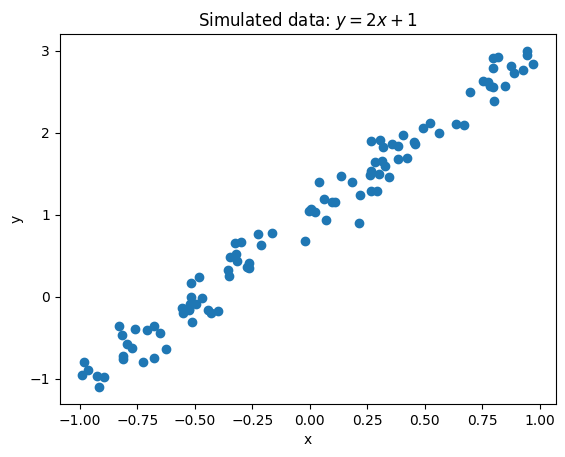

In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(42)

noise = np.random.randn(100) * 0.2
x = np.random.uniform(-1, 1, size=100) # 100 valies between -1 and 1
y = 2*x + noise + 1 # slope: 2, intercept: 1

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set(xlabel="x", ylabel="y", title="Simulated data: $y=2x+1$");

Having generated data with a slope of 2 and an intercept of 1, we can train the perceptron by running multiple iterations (epochs). At each step, we measure the current prediction error and then adjust our parameters so that next time the errors will be smaller.

We won’t dive into the full derivation here, but the key intuition is this: the weight update is proportional to the error $(y_\text{pred}-y)$ *and* to how sensitive the prediction is to that weight (which is exactly the input $x$). In other words, when $x$ is large, a small change in $w$ has a big effect on the prediction, so you nudge $w$ more in that direction.

In [2]:
# Initialize parameters
w = np.random.randn()
b = 0.0
lr = 0.05
epochs = 200

# Training loop
for epoch in range(epochs):
    # Forward pass
    y_pred = w * x + b

    # Compute loss (MSE)
    error = y_pred - y
    loss = np.mean(error**2)

    # Backward pass (gradients)
    dw = 2 * np.mean(error * x)
    db = 2 * np.mean(error)

    # Parameter update
    w -= lr * dw
    b -= lr * db

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d}, Loss {loss:.4f}, w {w:.3f}, b {b:.3f}")

# Result
print(f"\nLearned: y = {w:.2f} x + {b:.2f}")

Epoch   0, Loss 2.2388, w 0.077, b 0.092
Epoch  50, Loss 0.0819, w 1.665, b 0.961
Epoch 100, Loss 0.0339, w 1.970, b 0.977
Epoch 150, Loss 0.0322, w 2.028, b 0.980

Learned: y = 2.04 x + 0.98


You can see that the model recovers $w\approx2$ and $b\approx1$, demonstrating that a single linear perceptron can indeed perform regression.


## Beyond Single Perceptrons

Once you replace identity with nonlinear activations (ReLU, sigmoid, etc.) and stack multiple layers, a neural network can (under mild conditions) approximate any continuous function, which is the essence of deep learning.

```{figure} figures/network_zoo.png
:name: Network Architectures
:alt: Architectures
:align: center

A collection of well-known architectures (https://www.asimovinstitute.org/neural-network-zoo/).
```

The usual machine learning lingo is:

* Input layer: just forwards your raw features.
* Hidden layers: intermediate transformations (nonlinear) of the data.
* Output layer: produces final predictions (regression values or class probabilities).


### Activation Functions

Some of the most widely used activation functions and their applications are:

| Function         | Formula                                           | Use case                               |
| ---------------- | ------------------------------------------------- | -------------------------------------- |
| Identity         | $f(z)=z$                                          | Regression output layer                |
| Step             | $f(z)=\begin{cases}1 & z>0\\0 & z\le0\end{cases}$ | Binary classification (historical)     |
| Sigmoid          | $f(z)=\frac{1}{1+e^{-z}}$                         | Probabilities in binary classification |
| ReLU             | $f(z)=\max(0,z)$                                  | Hidden layers, sparse activations      |

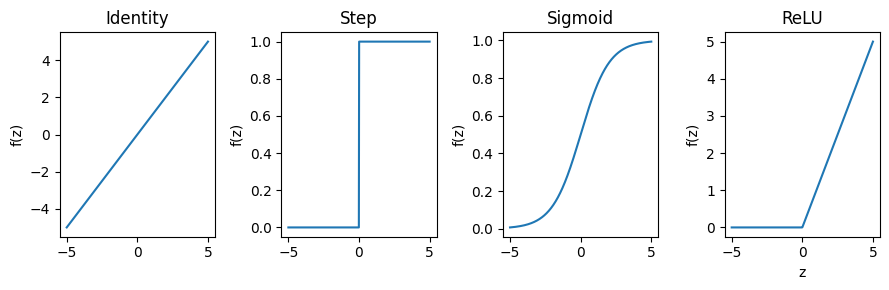

In [3]:
z = np.linspace(-5, 5, 500)

# Compute activations
identity = z
step = np.where(z > 0, 1, 0)
sigmoid = 1 / (1 + np.exp(-z))
relu = np.maximum(0, z)

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(9,3), sharex=True)

# Plot each activation
axes[0].plot(z, identity)
axes[0].set_title('Identity')
axes[0].set_ylabel('f(z)')

axes[1].plot(z, step)
axes[1].set_title('Step')
axes[1].set_ylabel('f(z)')

axes[2].plot(z, sigmoid)
axes[2].set_title('Sigmoid')
axes[2].set_ylabel('f(z)')

axes[3].plot(z, relu)
axes[3].set_title('ReLU')
axes[3].set_xlabel('z')
axes[3].set_ylabel('f(z)')

plt.tight_layout()
plt.show()

### Forward Propagation

Given an input $\mathbf{x}$, the network computes layer by layer:

1. Linear step: $\mathbf{z}^{(l)} = \mathbf{W}^{(l)}\,\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$
2. Activation: $\mathbf{a}^{(l)} = f\bigl(\mathbf{z}^{(l)}\bigr)$

where $l$ indexes the layers and $\mathbf{a}^{(0)}=\mathbf{x}$.


### Training with Backpropagation

We will not dive into de details of backpropagation here. If you are interested, there are near infinite materials available online (e.g., [mlu explain](https://mlu-explain.github.io/neural-networks/) for a visual exploration or this [medium article](https://medium.com/analytics-vidhya/backpropagation-for-dummies-e069410fa585) for a more mathematical explanation).

In short, training works in the following way:

1. Choose a loss:

   * Regression: Mean squared error
     $\displaystyle \mathcal{L} = \frac1N\sum_{i=1}^N\bigl(\hat y_i - y_i\bigr)^2$
   * Classification: Cross-entropy

2. Compute gradients of the loss with respect to each weight and bias via the chain rule (backpropagation).

3. Update parameters using gradient descent:

   $$\theta \leftarrow \theta - \eta \,\frac{\partial \mathcal{L}}{\partial \theta}$$

   where $\eta$ is the learning rate.